In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/transactions-fraud-datasets/mcc_codes.json
/kaggle/input/transactions-fraud-datasets/users_data.csv
/kaggle/input/transactions-fraud-datasets/transactions_data.csv
/kaggle/input/transactions-fraud-datasets/cards_data.csv
/kaggle/input/transactions-fraud-datasets/train_fraud_labels.json


In [2]:
# Importing dependencies

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

plt.style.use("ggplot")

In [3]:
# Loading and Cleaning the data

root_data = "../input/transactions-fraud-datasets"

cards_data = pd.read_csv(f'{root_data}/cards_data.csv')
transactions_data = pd.read_csv(f'{root_data}/transactions_data.csv')
users_data = pd.read_csv(f'{root_data}/users_data.csv')
fraud_labels = pd.read_json(f'{root_data}/train_fraud_labels.json')

with open(f'{root_data}/mcc_codes.json','r') as file:
    data = json.load(file)

merchant_category_codes = pd.DataFrame(list(data.items()),columns=['Code','Category'])

In [4]:
cards_data.head()

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,42,825,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No


In [5]:
cards_data.rename(columns={'id':'card_id'},inplace=True)

In [6]:
cards_data.dtypes

card_id                   int64
client_id                 int64
card_brand               object
card_type                object
card_number               int64
expires                  object
cvv                       int64
has_chip                 object
num_cards_issued          int64
credit_limit             object
acct_open_date           object
year_pin_last_changed     int64
card_on_dark_web         object
dtype: object

In [7]:
cards_data['expires'] = pd.to_datetime(cards_data['expires'],format='%m/%Y')
cards_data['credit_limit'] = cards_data['credit_limit'].str.replace('$','').astype('int')
cards_data['acct_open_date'] = pd.to_datetime(cards_data['acct_open_date'],format='%m/%Y')
cards_data['year_pin_last_changed'] = pd.to_datetime(cards_data['year_pin_last_changed'],format='%Y')

In [8]:
cards_data.isna().sum()

card_id                  0
client_id                0
card_brand               0
card_type                0
card_number              0
expires                  0
cvv                      0
has_chip                 0
num_cards_issued         0
credit_limit             0
acct_open_date           0
year_pin_last_changed    0
card_on_dark_web         0
dtype: int64

In [9]:
transactions_data.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN


In [10]:
transactions_data.rename(columns={'id':'transaction_id'},inplace=True)

In [11]:
transactions_data.dtypes

transaction_id      int64
date               object
client_id           int64
card_id             int64
amount             object
use_chip           object
merchant_id         int64
merchant_city      object
merchant_state     object
zip               float64
mcc                 int64
errors             object
dtype: object

In [12]:
transactions_data['date'] = pd.to_datetime(transactions_data['date'])
transactions_data['amount'] = pd.to_numeric(transactions_data['amount'].str.replace('$',''))

In [13]:
transactions_data.isna().sum()

transaction_id           0
date                     0
client_id                0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state     1563700
zip                1652706
mcc                      0
errors            13094522
dtype: int64

In [14]:
users_data.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1


In [15]:
users_data.rename(columns={'id':'client_id'},inplace=True)

In [16]:
users_data['birth_date'] = users_data['birth_month'].astype(str) + '/' + users_data['birth_year'].astype(str)
users_data.drop(['birth_year','birth_month'],axis=1,inplace=True)

In [17]:
users_data.dtypes

client_id              int64
current_age            int64
retirement_age         int64
gender                object
address               object
latitude             float64
longitude            float64
per_capita_income     object
yearly_income         object
total_debt            object
credit_score           int64
num_credit_cards       int64
birth_date            object
dtype: object

In [18]:
users_data['per_capita_income'] = users_data['per_capita_income'].str.replace('$','').astype(int)
users_data['yearly_income'] = users_data['yearly_income'].str.replace('$','').astype(int)
users_data['total_debt'] = users_data['total_debt'].str.replace('$','').astype(int)
users_data['birth_date'] = pd.to_datetime(users_data['birth_date'],format = '%m/%Y')

In [19]:
users_data.isna().sum()

client_id            0
current_age          0
retirement_age       0
gender               0
address              0
latitude             0
longitude            0
per_capita_income    0
yearly_income        0
total_debt           0
credit_score         0
num_credit_cards     0
birth_date           0
dtype: int64

In [20]:
fraud_labels.reset_index(inplace=True)
fraud_labels.head()

,index,target
0,10649266,No
1,23410063,No
2,9316588,No
3,12478022,No
4,9558530,No


In [21]:
fraud_labels.rename(columns={'index': 'transaction_id'},inplace=True)

In [22]:
merchant_category_codes.head()

,Code,Category
0,5812,Eating Places and Restaurants
1,5541,Service Stations
2,7996,"Amusement Parks, Carnivals, Circuses"
3,5411,"Grocery Stores, Supermarkets"
4,4784,Tolls and Bridge Fees


In [23]:
merchant_category_codes['Code']= merchant_category_codes['Code'].astype(int)

In [24]:
merchant_category_codes.dtypes

Code         int64
Category    object
dtype: object

In [25]:
# Merging cards_data and users_data

Merged_data= pd.merge(cards_data,users_data,left_on='client_id',right_on='client_id',how='inner')

In [26]:
# Merging Fraud_labels and Transactions_data on Transaction_id

Merged_fraud_labels_data = pd.merge(transactions_data,fraud_labels,on='transaction_id',how='inner')

In [27]:
# Extracting the fraud_transactions data

fraud_transactions = Merged_fraud_labels_data.query('target=="Yes"')
fraud_transactions = pd.merge(fraud_transactions,merchant_category_codes,left_on='mcc',right_on='Code',how='inner')
fraud_transactions = pd.merge(fraud_transactions,users_data,on='client_id',how='inner')

In [28]:
fraud_transactions.head()

,transaction_id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,birth_date
0,7479444,2010-01-01 23:56:00,126,5497,0.19,Online Transaction,90999,ONLINE,NaN,NaN,...,Male,5159 Wessex Avenue,34.72,-92.35,13047,26600,0,799,4,1956-10-01
1,7486725,2010-01-03 20:58:00,126,5497,339.00,Online Transaction,3558,ONLINE,NaN,NaN,...,Male,5159 Wessex Avenue,34.72,-92.35,13047,26600,0,799,4,1956-10-01
2,7490901,2010-01-04 23:30:00,720,4136,4.45,Online Transaction,24504,ONLINE,NaN,NaN,...,Female,980 Federal Drive,42.38,-83.10,9710,19800,40038,682,3,1983-05-01
3,7490914,2010-01-04 23:48:00,720,4136,7.19,Online Transaction,38602,ONLINE,NaN,NaN,...,Female,980 Federal Drive,42.38,-83.10,9710,19800,40038,682,3,1983-05-01
4,7491008,2010-01-05 02:34:00,1644,3444,8.76,Online Transaction,21776,ONLINE,NaN,NaN,...,Male,637 Seventh Street,34.66,-83.09,15406,31943,1248,686,6,1937-01-01


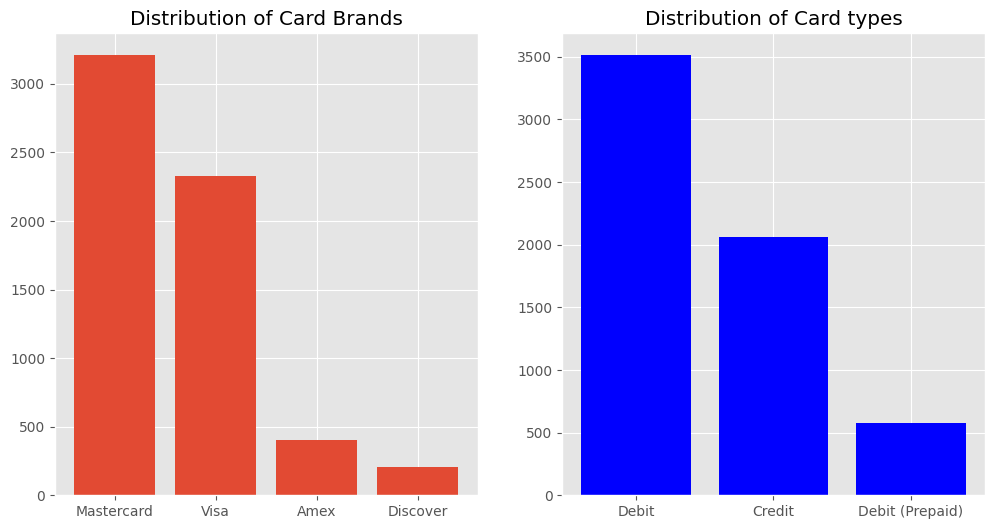

In [29]:
# Visualizing Data

fig, ax = plt.subplots(1,2,figsize=(12,6))

keys = cards_data['card_brand'].value_counts().keys()
values = cards_data['card_brand'].value_counts().values
ax[0].bar(keys,values)
ax[0].set_title('Distribution of Card Brands')

keys = cards_data['card_type'].value_counts().keys()
values = cards_data['card_type'].value_counts().values
ax[1].bar(keys,values,color='blue')
ax[1].set_title('Distribution of Card types')

plt.show()

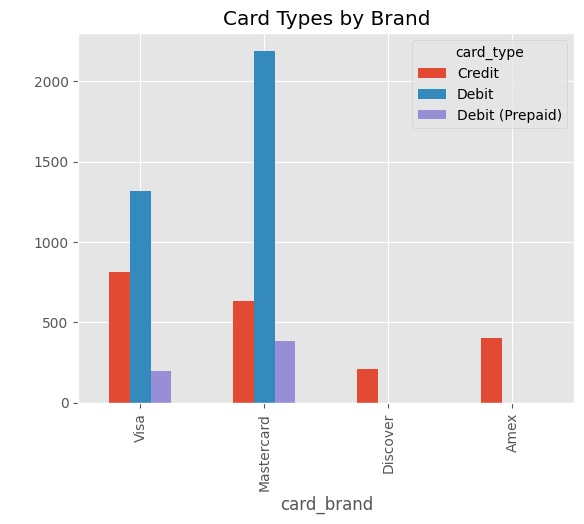

In [30]:
data = cards_data.groupby(['card_brand','card_type']).size().unstack()
data[::-1].plot(kind='bar', title='Card Types by Brand')
plt.ylabel(' ')
plt.show()

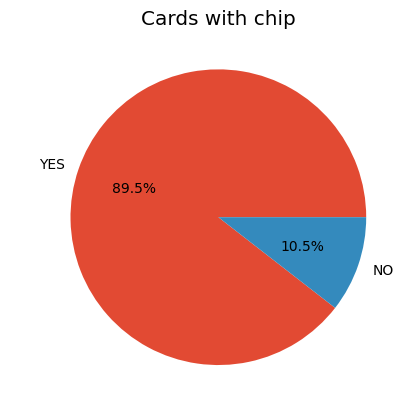

In [31]:
cards_data['has_chip'].value_counts().plot(kind='pie',autopct='%1.1f%%',title='Cards with chip')
plt.ylabel(' ')
plt.show()

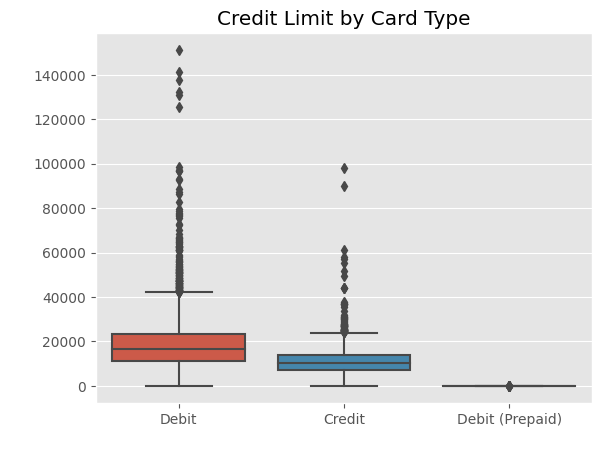

In [32]:
sns.boxplot(data=cards_data, x='card_type',y='credit_limit')
plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Credit Limit by Card Type')
plt.show()

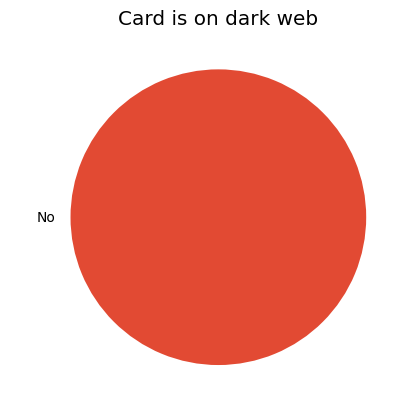

In [33]:
cards_data['card_on_dark_web'].value_counts().plot(kind='pie',title = 'Card is on dark web')
plt.ylabel(' ')
plt.show()

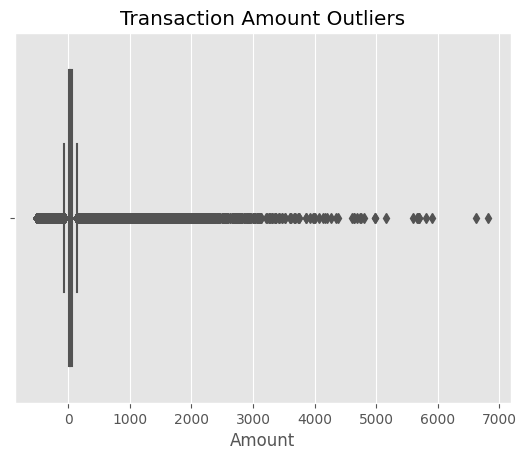

In [34]:
sns.boxplot(x=transactions_data['amount'])
plt.title('Transaction Amount Outliers')
plt.xlabel('Amount')
plt.show()

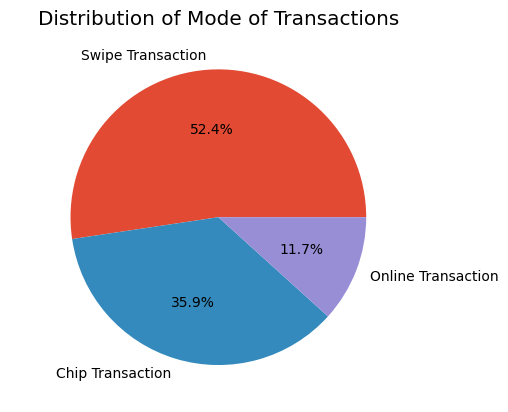

In [35]:
transactions_data['use_chip'].value_counts().plot(kind='pie',autopct='%1.1f%%',title='Distribution of Mode of Transactions')
plt.ylabel(' ')
plt.show()

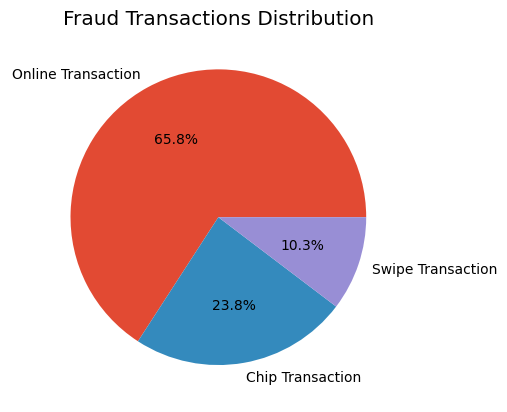

In [36]:
fraud_transactions['use_chip'].value_counts().plot(kind = 'pie', autopct= '%1.1f%%',title = 'Fraud Transactions Distribution')
plt.ylabel(' ')
plt.show()

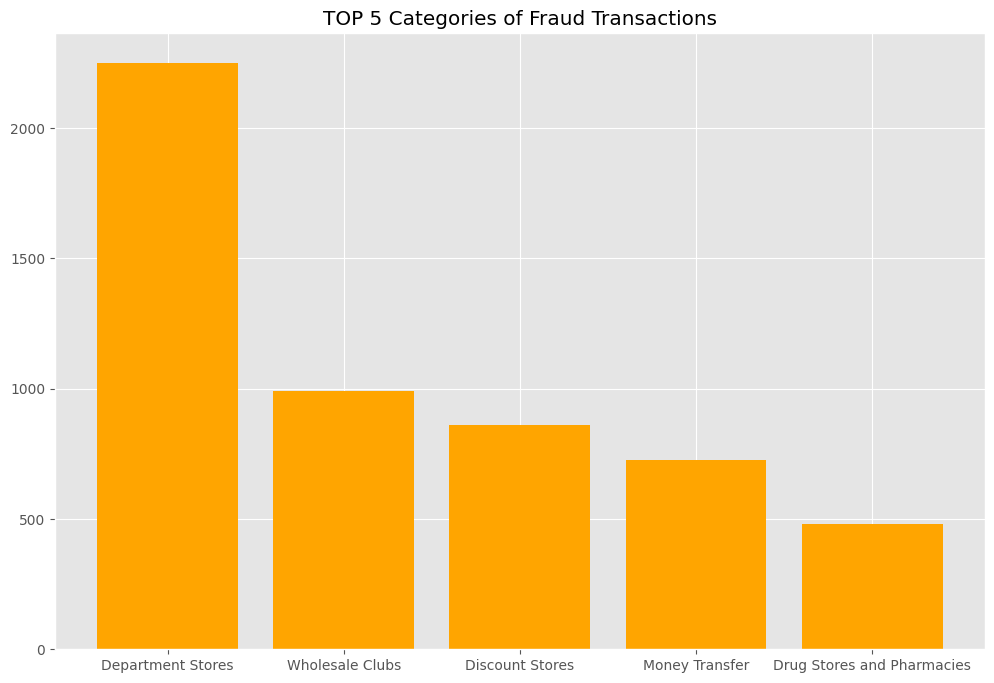

In [37]:
keys = fraud_transactions['Category'].value_counts().keys().tolist()[:5]
values = fraud_transactions['Category'].value_counts().values.tolist()[:5]


fig, ax = plt.subplots(figsize=(12,8))

ax.bar(keys,values,color='orange')
ax.set_title('TOP 5 Categories of Fraud Transactions')
plt.show()

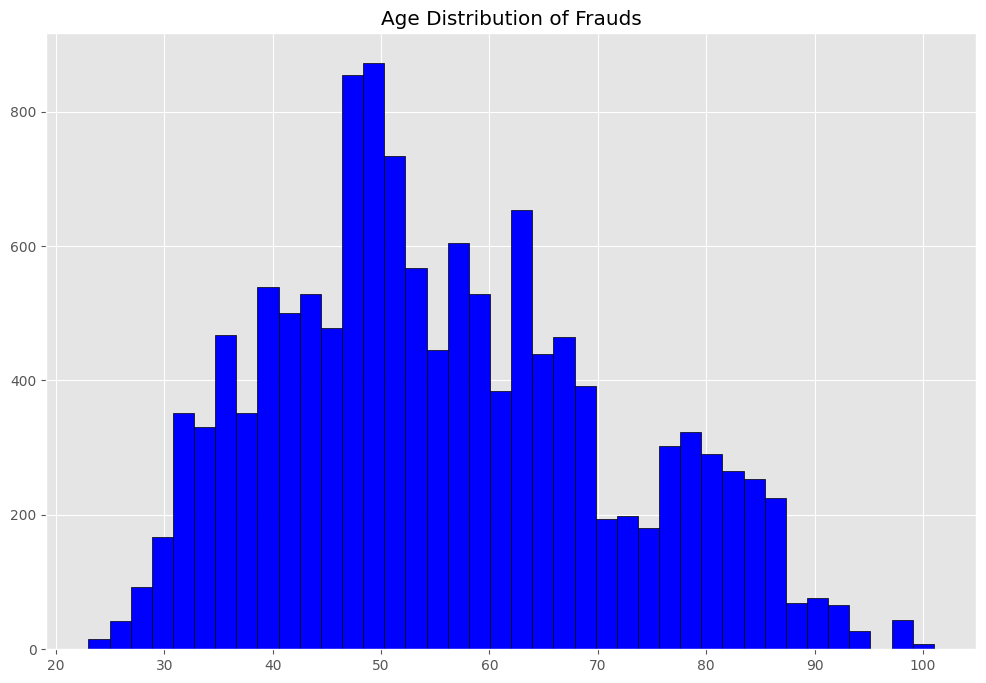

In [38]:
fig, ax = plt.subplots(figsize=(12,8))

ax.hist(fraud_transactions['current_age'],color='blue',bins=40,edgecolor='black')
ax.set_title('Age Distribution of Frauds')
plt.show()

In [39]:
fraud_transactions[fraud_transactions['amount']==fraud_transactions['amount'].max()]

,transaction_id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,birth_date
589,7808164,2010-03-26 07:00:00,1142,4674,4978.45,Online Transaction,9026,ONLINE,NaN,NaN,...,Male,544 Main Drive,42.15,-71.13,38878,79272,107029,716,3,1967-03-01


In [40]:
fraud_transactions.query('amount > 1000')

,transaction_id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,birth_date
19,7521993,2010-01-12 21:02:00,1048,2542,1014.41,Online Transaction,9026,ONLINE,NaN,NaN,...,Female,265 Ocean Drive,29.79,-95.82,26422,53878,78143,779,4,1960-12-01
24,7533803,2010-01-16 02:09:00,379,2019,1198.09,Online Transaction,47225,ONLINE,NaN,NaN,...,Female,837 Lincoln Avenue,30.68,-88.04,21331,43496,114563,765,3,1972-11-01
134,7603183,2010-02-02 15:38:00,1076,1021,1709.60,Online Transaction,39105,ONLINE,NaN,NaN,...,Female,3987 11th Drive,35.05,-78.87,18316,37342,48611,779,5,1958-08-01
145,7609332,2010-02-04 08:52:00,1100,5964,2010.57,Online Transaction,47225,ONLINE,NaN,NaN,...,Male,9888 Washington Boulevard,40.72,-73.51,29337,59815,73325,573,2,1958-07-01
269,7670009,2010-02-19 12:09:00,502,2018,2529.39,Online Transaction,9922,ONLINE,NaN,NaN,...,Male,434 Bayview Avenue,40.93,-79.59,17870,36440,30574,745,2,1974-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11862,22205534,2018-12-06 11:24:00,145,4058,1284.18,Chip Transaction,48919,Rome,Italy,NaN,...,Female,645 Hillside Lane,36.18,-82.07,12427,25334,182,696,3,1962-01-01
11892,22245052,2018-12-14 17:04:00,1586,1365,1141.46,Chip Transaction,30497,Rome,Italy,NaN,...,Male,2974 Grant Avenue,40.66,-73.70,27778,56640,104134,672,4,1977-01-01
11989,22343207,2019-01-04 13:10:00,1942,246,1135.92,Chip Transaction,31893,Rome,Italy,NaN,...,Female,2073 South Avenue,40.71,-73.99,0,1,0,673,3,1942-03-01
12852,23274539,2019-07-20 15:09:00,779,119,1244.41,Chip Transaction,2297,Rome,Italy,NaN,...,Female,44 Valley Boulevard,33.77,-96.67,20874,32669,1433,755,5,1938-03-01


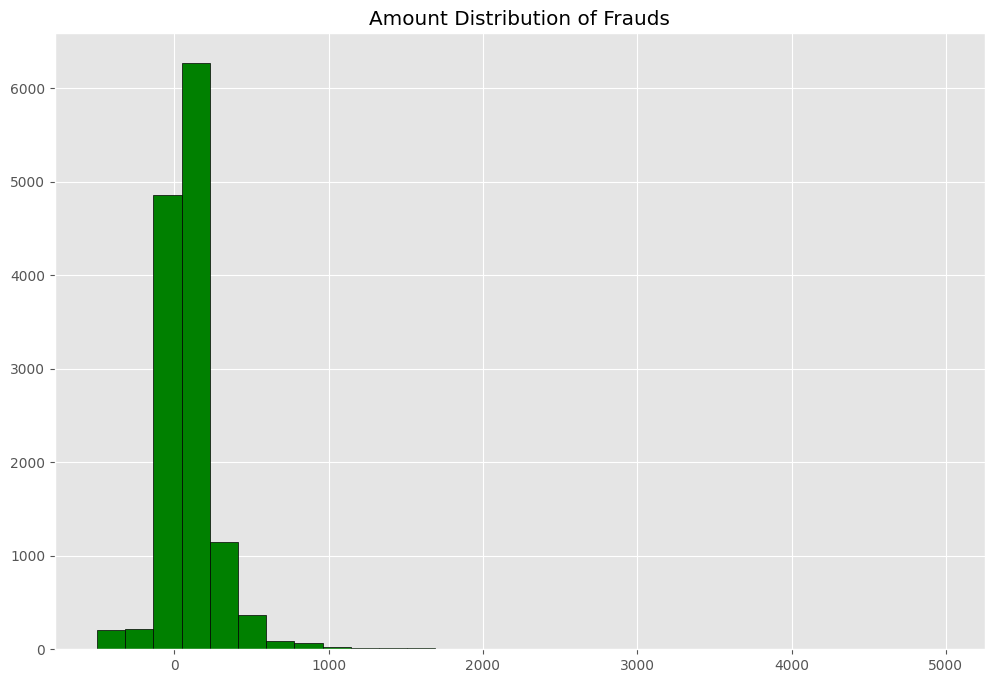

In [41]:
fig, ax = plt.subplots(figsize=(12,8))

ax.hist(fraud_transactions['amount'],bins=30,color='green',edgecolor='black')
ax.set_title('Amount Distribution of Frauds')
plt.show()